## Imports

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

In [25]:
IMG_SIZE = 256
PATCH_SIZE = 3
SIGMA = 0.015
FEATURE_DIM = 1536

## Modules

In [26]:
class MVTecDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.img_paths = [
            os.path.join(dp, f)
            for dp, _, fn in os.walk(root)
            for f in fn if f.endswith(".png") or f.endswith(".jpg")
        ]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [27]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        wrn50 = models.wide_resnet50_2(pretrained=True)
        self.layer2 = nn.Sequential(*list(wrn50.children())[:6])
        self.layer3 = nn.Sequential(*list(wrn50.children())[6])

    def forward(self, x):
        f2 = self.layer2(x)
        f3 = self.layer3(f2)
        f2 = F.adaptive_avg_pool2d(f2, f3.shape[-2:])
        out = torch.cat([f2, f3], dim=1)
        return out

In [28]:
class FeatureAdapter(nn.Module):
    def __init__(self, dim=FEATURE_DIM):
        super().__init__()
        self.fc = nn.Linear(dim, dim, bias=False)

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(-1, c)
        x = self.fc(x)
        return x.reshape(b, h, w, c).permute(0, 3, 1, 2)


class Discriminator(nn.Module):
    def __init__(self, dim=FEATURE_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.LeakyReLU(0.2),
            nn.Linear(dim, 1)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(-1, c)
        out = self.net(x)
        return out.reshape(b, h, w)

In [29]:
def truncated_l1_loss(pos, neg, th_pos=0.5, th_neg=-0.5):
    return F.relu(th_pos - pos).mean() + F.relu(neg + th_neg).mean()

## SimpleNet

In [30]:
def train_one_epoch(model_parts, dataloader, optimizers):
    F_phi, G_theta, D_psi = model_parts
    opt_G, opt_D = optimizers
    
    for imgs in dataloader:
        imgs = imgs.cuda()
        with torch.no_grad():
            feats = F_phi(imgs)
        adapted = G_theta(feats)
        noise = torch.randn_like(adapted) * SIGMA
        fake = adapted + noise

        score_pos = D_psi(adapted)
        score_neg = D_psi(fake)
        loss = truncated_l1_loss(score_pos, score_neg)

        opt_G.zero_grad()
        opt_D.zero_grad()
        loss.backward()
        opt_G.step()
        opt_D.step()

In [31]:
def infer_anomaly_map(F_phi, G_theta, D_psi, img):
    with torch.no_grad():
        feat = F_phi(img.unsqueeze(0).cuda())
        adapted = G_theta(feat)
        score_map = -D_psi(adapted)
        score_map = F.interpolate(score_map.unsqueeze(1), size=(IMG_SIZE, IMG_SIZE), mode='bilinear')
        return score_map.squeeze().cpu().numpy()


In [32]:
MVTec_ROOT = "/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection"
SAVE_DIR = "./saved_weights"
os.makedirs(SAVE_DIR, exist_ok=True)

In [20]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])

categories = sorted(os.listdir(MVTec_ROOT))

for category in categories:
    train_dir = os.path.join(MVTec_ROOT, category, "train", "good")
    if not os.path.exists(train_dir):
        continue

    print(f"\nTraining on category: {category}")

    dataset = MVTecDataset(train_dir, transform)
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    F_phi = FeatureExtractor().cuda().eval()
    G_theta = FeatureAdapter().cuda()
    D_psi = Discriminator().cuda()

    opt_G = torch.optim.Adam(G_theta.parameters(), lr=1e-4, weight_decay=1e-5)
    opt_D = torch.optim.Adam(D_psi.parameters(), lr=2e-4, weight_decay=1e-5)

    EPOCHS = 10
    pbar = tqdm(range(EPOCHS), desc=f"Epochs ({category})", ncols=100)
    for epoch in pbar:
        train_one_epoch((F_phi, G_theta, D_psi), loader, (opt_G, opt_D))
        pbar.set_postfix({"epoch": epoch+1})

    # Save model weights
    torch.save(G_theta.state_dict(), os.path.join(SAVE_DIR, f"G_theta_{category}.pth"))
    torch.save(D_psi.state_dict(), os.path.join(SAVE_DIR, f"D_psi_{category}.pth"))
    print(f"Weights saved for category: {category}")



Training on category: bottle


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epochs (bottle): 100%|████████████████████████████████████| 10/10 [01:06<00:00,  6.70s/it, epoch=10]


Weights saved for category: bottle

Training on category: cable


Epochs (cable): 100%|█████████████████████████████████████| 10/10 [01:57<00:00, 11.79s/it, epoch=10]


Weights saved for category: cable

Training on category: capsule


Epochs (capsule): 100%|███████████████████████████████████| 10/10 [01:54<00:00, 11.40s/it, epoch=10]


Weights saved for category: capsule

Training on category: carpet


Epochs (carpet): 100%|████████████████████████████████████| 10/10 [02:21<00:00, 14.10s/it, epoch=10]


Weights saved for category: carpet

Training on category: grid


Epochs (grid): 100%|██████████████████████████████████████| 10/10 [01:07<00:00,  6.77s/it, epoch=10]


Weights saved for category: grid

Training on category: hazelnut


Epochs (hazelnut): 100%|██████████████████████████████████| 10/10 [03:15<00:00, 19.52s/it, epoch=10]


Weights saved for category: hazelnut

Training on category: leather


Epochs (leather): 100%|███████████████████████████████████| 10/10 [01:39<00:00,  9.93s/it, epoch=10]


Weights saved for category: leather

Training on category: metal_nut


Epochs (metal_nut): 100%|█████████████████████████████████| 10/10 [00:56<00:00,  5.62s/it, epoch=10]


Weights saved for category: metal_nut

Training on category: pill


Epochs (pill): 100%|██████████████████████████████████████| 10/10 [01:28<00:00,  8.89s/it, epoch=10]


Weights saved for category: pill

Training on category: screw


Epochs (screw): 100%|█████████████████████████████████████| 10/10 [01:23<00:00,  8.36s/it, epoch=10]


Weights saved for category: screw

Training on category: tile


Epochs (tile): 100%|██████████████████████████████████████| 10/10 [01:25<00:00,  8.59s/it, epoch=10]


Weights saved for category: tile

Training on category: toothbrush


Epochs (toothbrush): 100%|████████████████████████████████| 10/10 [00:31<00:00,  3.13s/it, epoch=10]


Weights saved for category: toothbrush

Training on category: transistor


Epochs (transistor): 100%|████████████████████████████████| 10/10 [01:56<00:00, 11.65s/it, epoch=10]


Weights saved for category: transistor

Training on category: wood


Epochs (wood): 100%|██████████████████████████████████████| 10/10 [02:05<00:00, 12.51s/it, epoch=10]


Weights saved for category: wood

Training on category: zipper


Epochs (zipper): 100%|████████████████████████████████████| 10/10 [00:58<00:00,  5.82s/it, epoch=10]

Weights saved for category: zipper


## Evaluation

In [33]:
class MVTecDataset(Dataset):
    def __init__(self, root, transform=None, mask=False):
        self.root = root
        self.transform = transform
        self.mask = mask
        self.img_paths = []
        self.mask_paths = []

        for defect_type in os.listdir(os.path.join(root, 'test')):
            defect_folder = os.path.join(root, 'test', defect_type)
            for f in os.listdir(defect_folder):
                self.img_paths.append(os.path.join(defect_folder, f))
                if self.mask and defect_type != 'good':
                    mask_path = os.path.join(root, 'ground_truth', defect_type, f.replace('.png', '_mask.png'))
                    self.mask_paths.append(mask_path)
                else:
                    self.mask_paths.append(None)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.mask_paths[idx] and os.path.exists(self.mask_paths[idx]):
            mask = Image.open(self.mask_paths[idx]).convert("L")
            mask = self.transform(mask)[0]
        else:
            mask = torch.zeros(IMG_SIZE, IMG_SIZE)  # zero-mask for 'good' samples or missing masks

        return img, mask, self.img_paths[idx]

In [34]:
def evaluate(model_parts, dataloader,cat):
    F_phi, G_theta, D_psi = model_parts
    all_pixel_scores = []
    all_pixel_labels = []
    all_image_scores = []
    all_image_labels = []
    viz_data = []

    for img, mask, path in dataloader:
        img = img.cuda()
        score_map = infer_anomaly_map(F_phi, G_theta, D_psi, img[0])

        if mask is not None:
            mask = (mask.squeeze().numpy() > 0.5).astype(np.uint8)
            all_pixel_scores.extend(score_map.flatten())
            all_pixel_labels.extend(mask.flatten())

            # Image-level score and label
            all_image_scores.append(score_map.max())
            all_image_labels.append(int(mask.max() > 0))

            if len(viz_data) < 8 and np.max(mask) > 0:
                viz_data.append((img[0].permute(1, 2, 0).cpu().numpy(), score_map, mask))

    pixel_auroc = roc_auc_score(all_pixel_labels, all_pixel_scores)
    image_auroc = roc_auc_score(all_image_labels, all_image_scores)
    print(f"\n{cat}: AUROC: {100*image_auroc:.2f}% / {100*pixel_auroc:.2f}% (image / pixel)")
    # print(f"Pixel-wise AUROC: {pixel_auroc:.4f}")
    # print(f"Image-wise AUROC: {image_auroc:.4f}")

    # Plot
    fig, axs = plt.subplots(2, 8, figsize=(20, 5))
    for i, (img, score, mask) in enumerate(viz_data):
        axs[0, i].imshow(score, cmap='inferno')
        axs[0, i].set_title("Predicted")
        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].set_title("Ground Truth")
        axs[0, i].axis('off')
        axs[1, i].axis('off')
    plt.tight_layout()
    plt.show()

In [35]:
def infer_anomaly_map(F_phi, G_theta, D_psi, img):
    with torch.no_grad():
        feat = F_phi(img.unsqueeze(0).cuda())
        adapted = G_theta(feat)
        score_map = -D_psi(adapted)
        score_map = F.interpolate(score_map.unsqueeze(1), size=(IMG_SIZE, IMG_SIZE), mode='bilinear')
        return score_map.squeeze().cpu().numpy()



Evaluating category: bottle


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



bottle: AUROC: 98.49% / 82.75% (image / pixel)


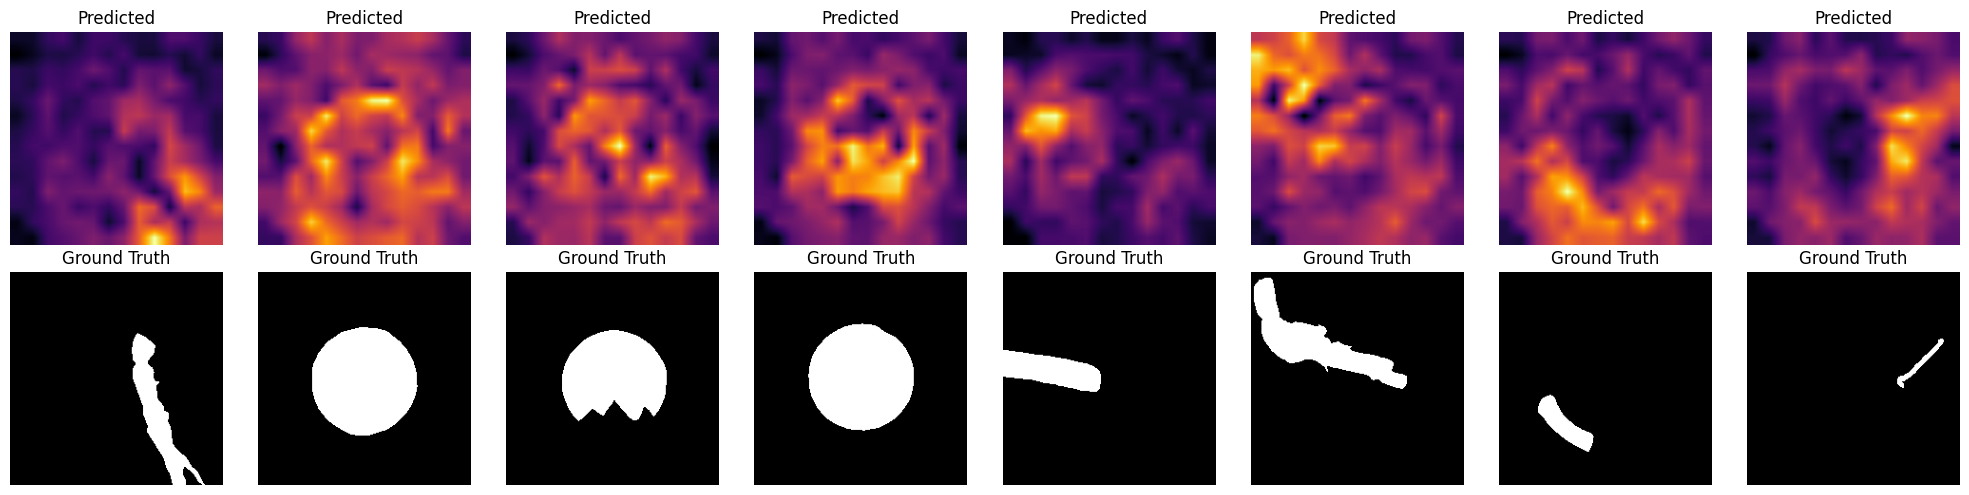


Evaluating category: cable


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



cable: AUROC: 88.08% / 79.62% (image / pixel)


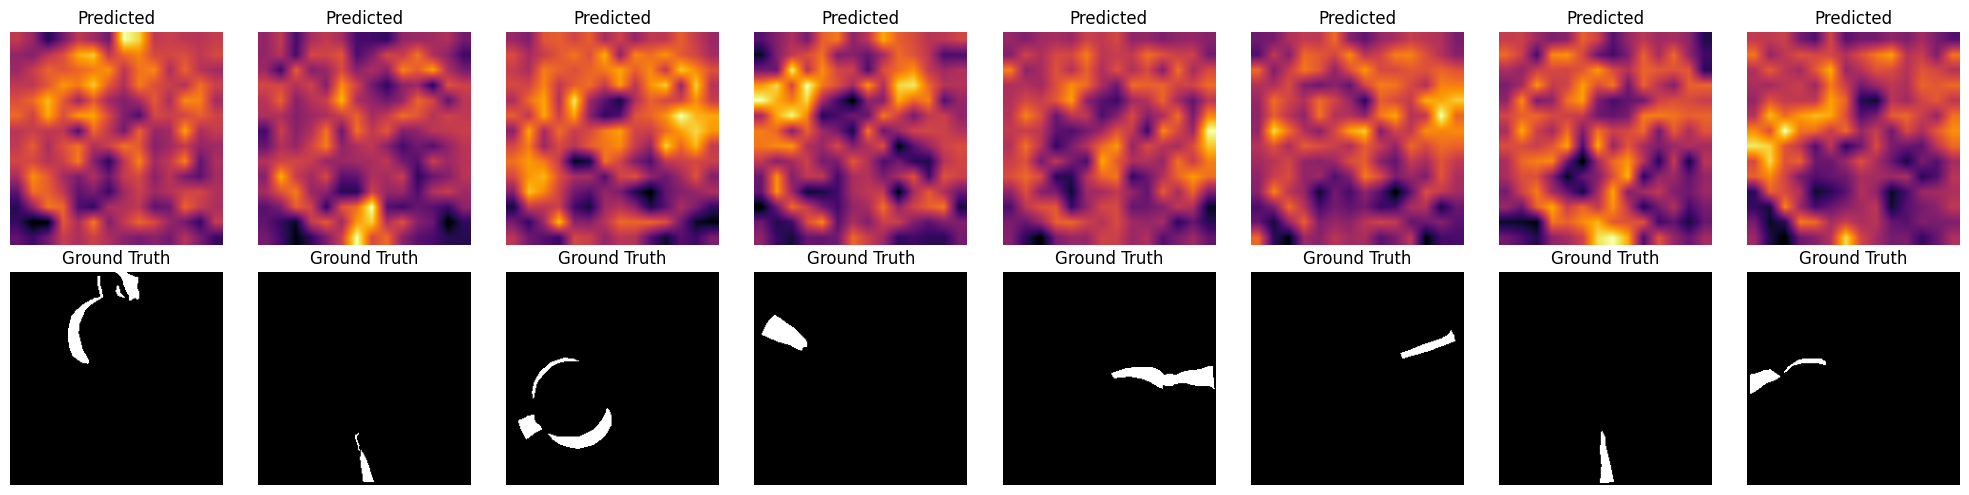


Evaluating category: capsule


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



capsule: AUROC: 90.03% / 95.23% (image / pixel)


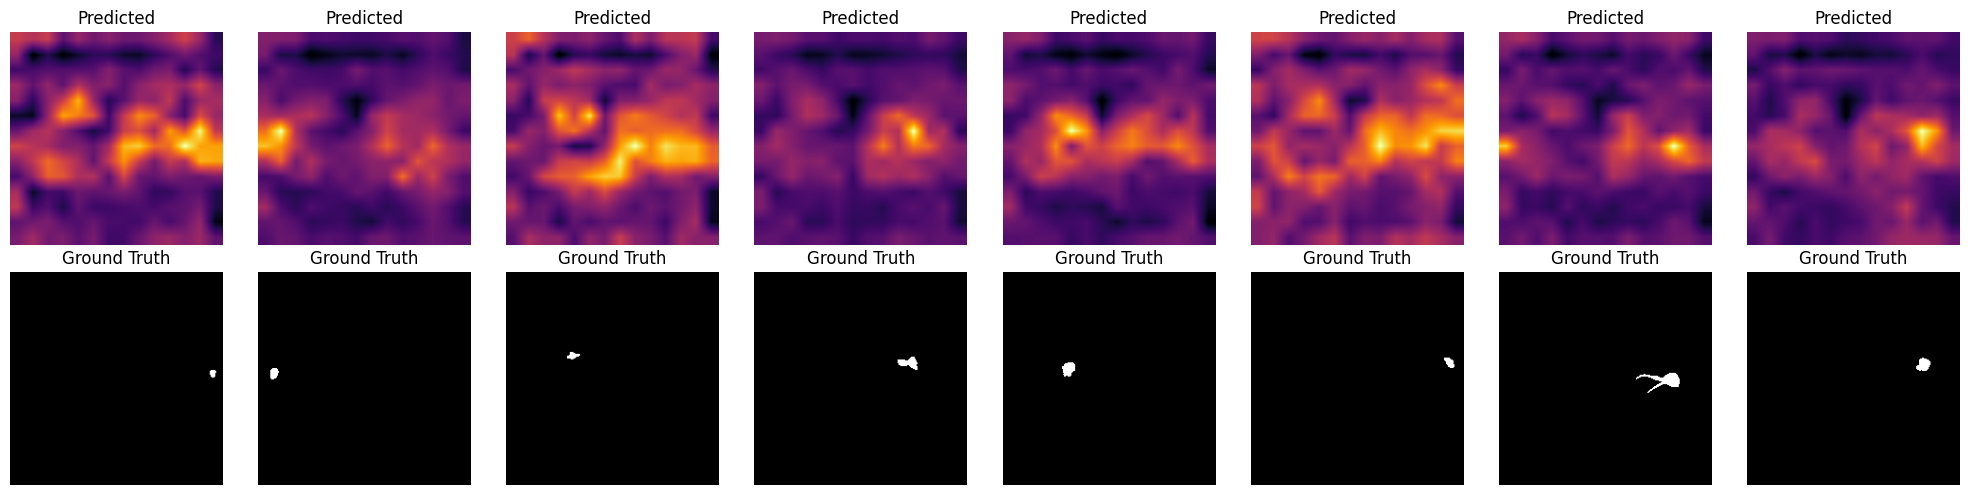


Evaluating category: carpet


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



carpet: AUROC: 93.86% / 75.40% (image / pixel)


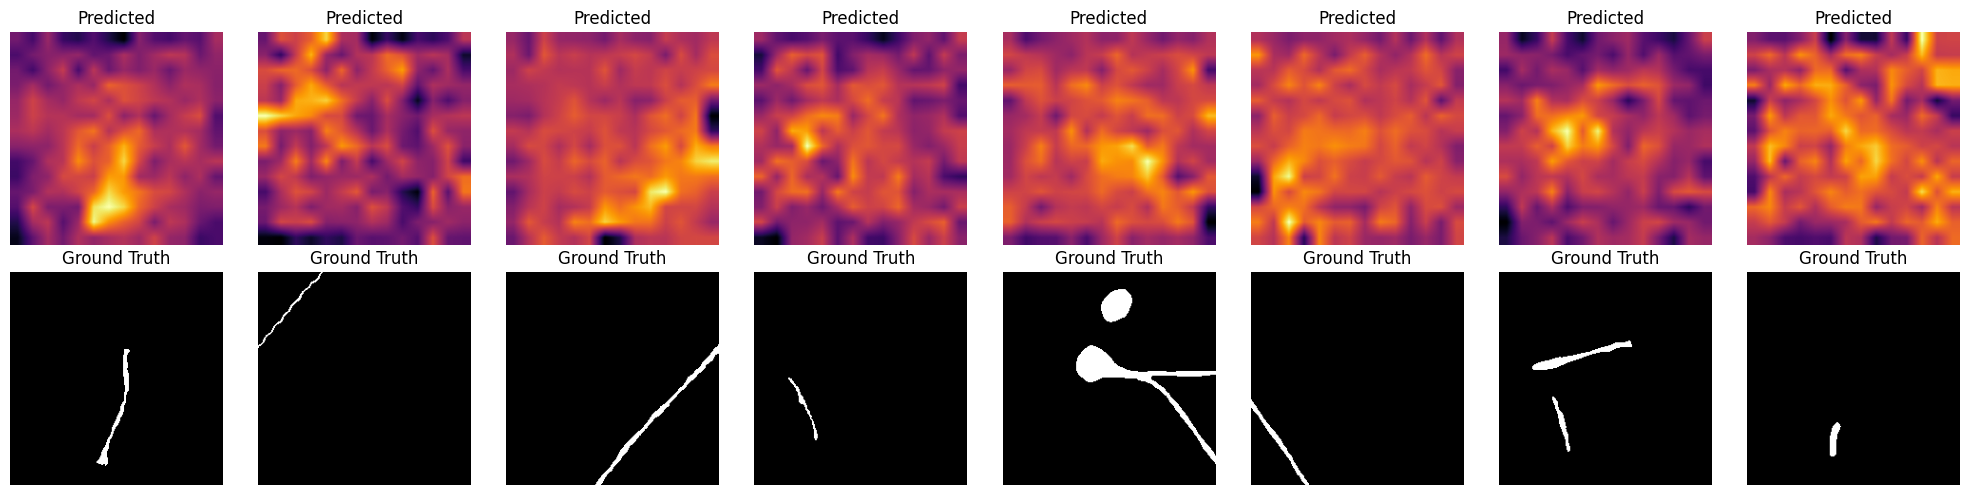


Evaluating category: grid


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



grid: AUROC: 92.94% / 87.87% (image / pixel)


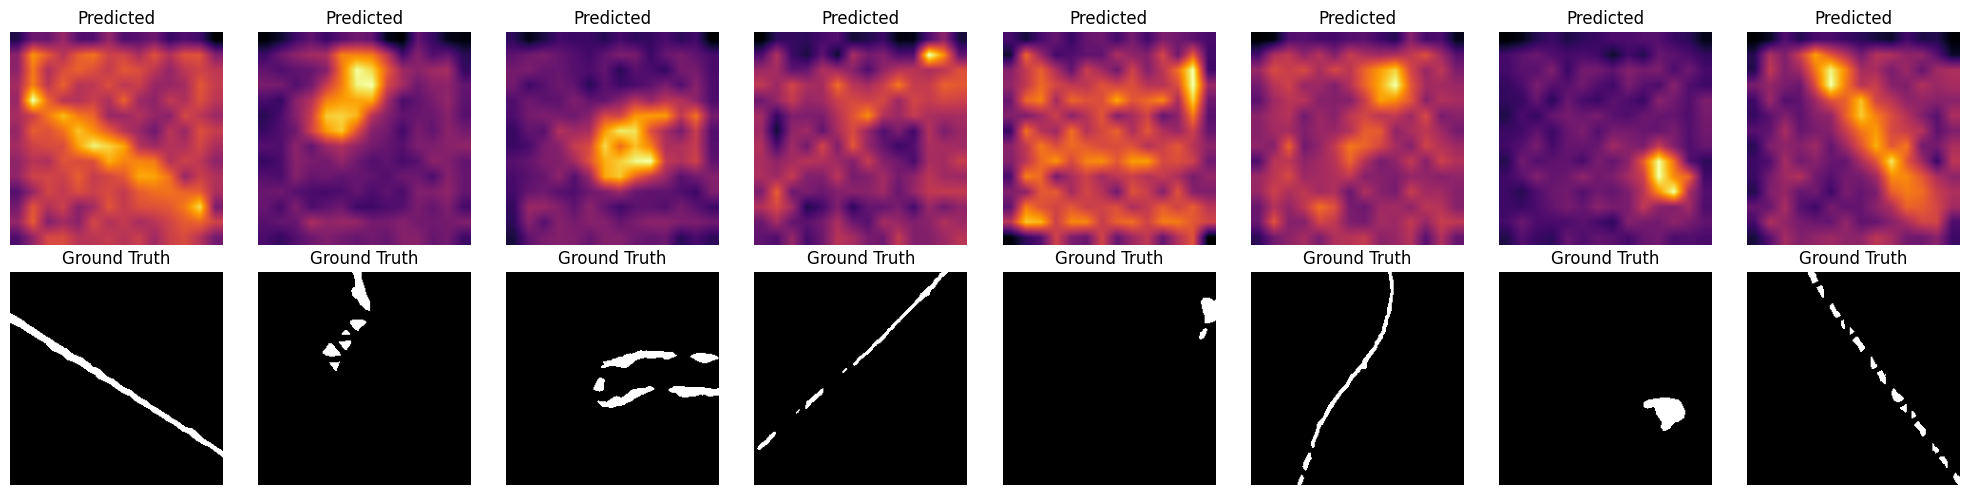


Evaluating category: hazelnut


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



hazelnut: AUROC: 60.04% / 68.99% (image / pixel)


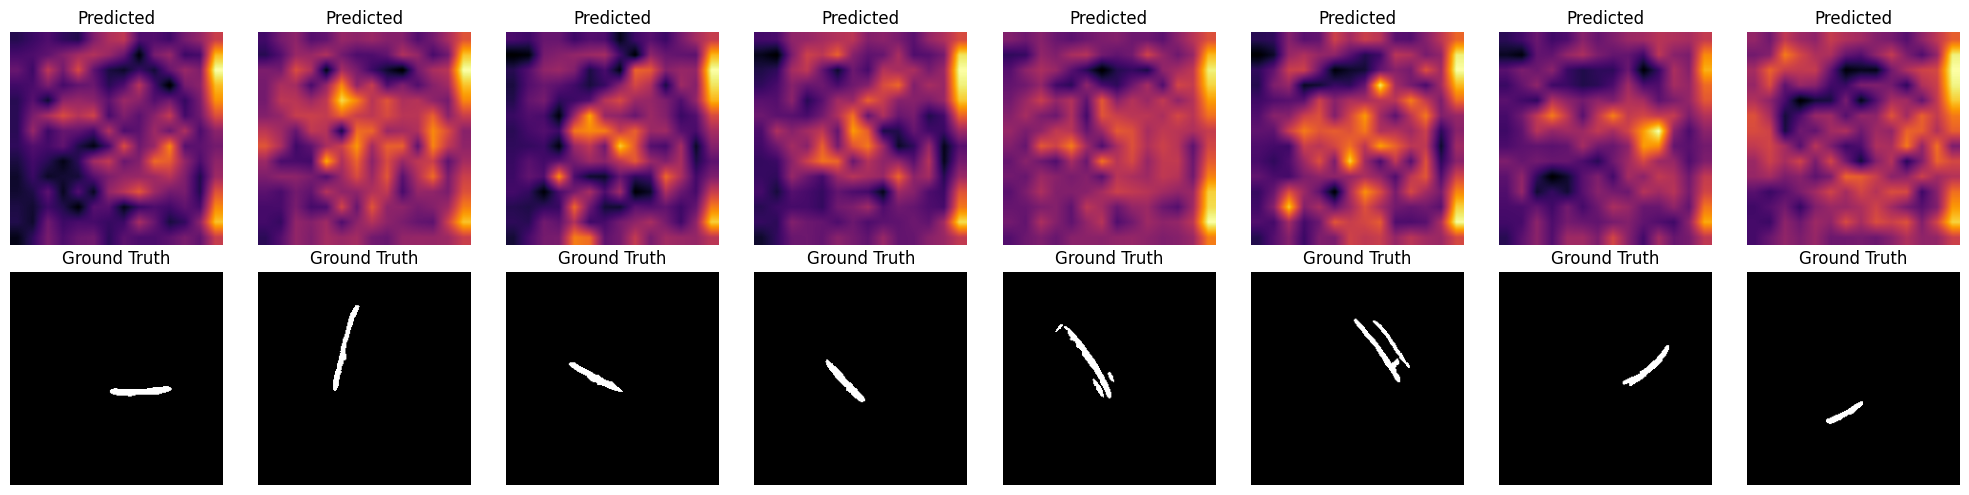


Evaluating category: leather


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



leather: AUROC: 84.14% / 87.19% (image / pixel)


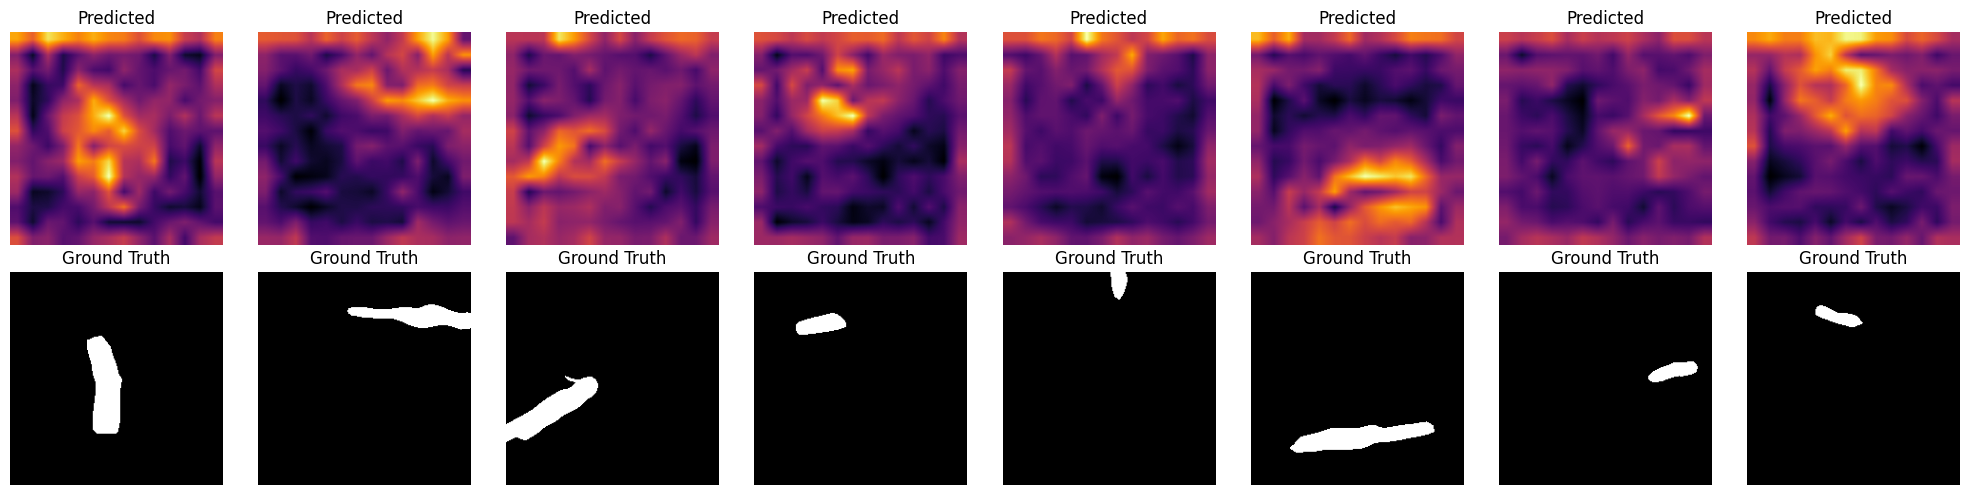


Evaluating category: metal_nut


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



metal_nut: AUROC: 71.36% / 89.96% (image / pixel)


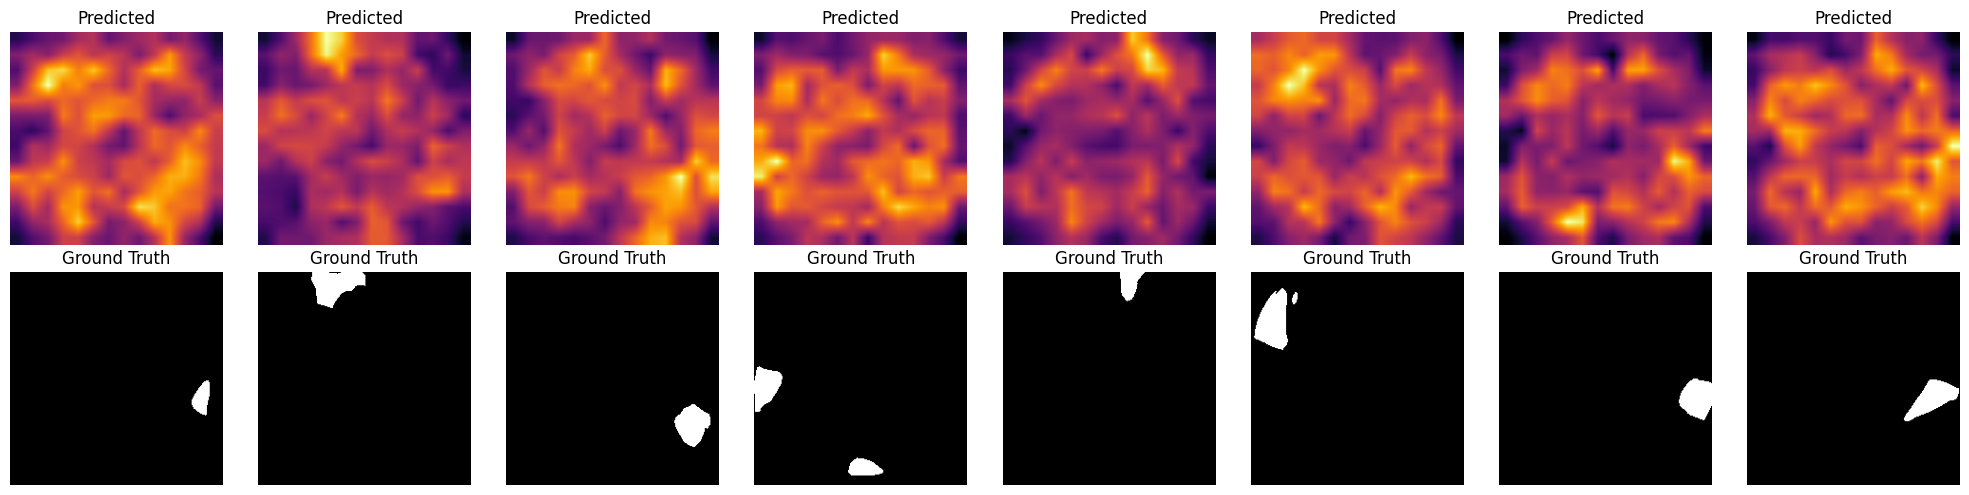


Evaluating category: pill


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



pill: AUROC: 71.09% / 86.19% (image / pixel)


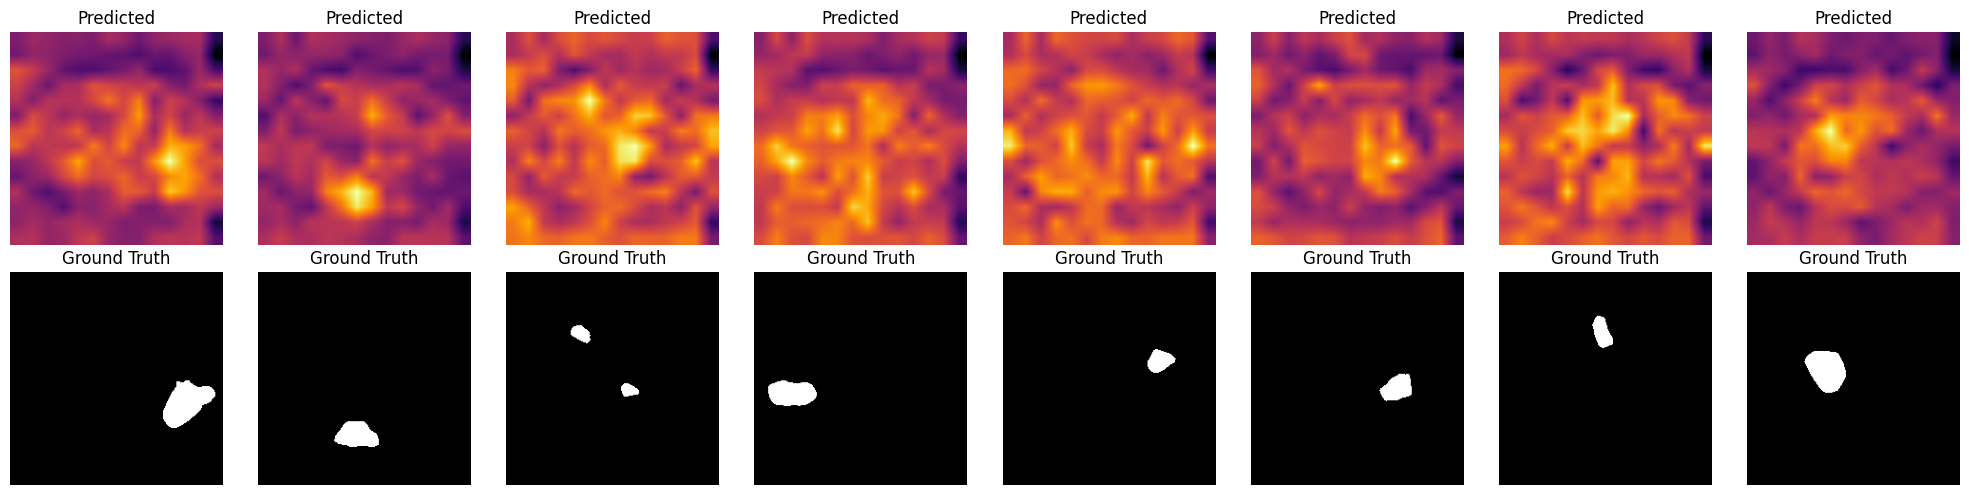


Evaluating category: screw


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



screw: AUROC: 69.34% / 76.93% (image / pixel)


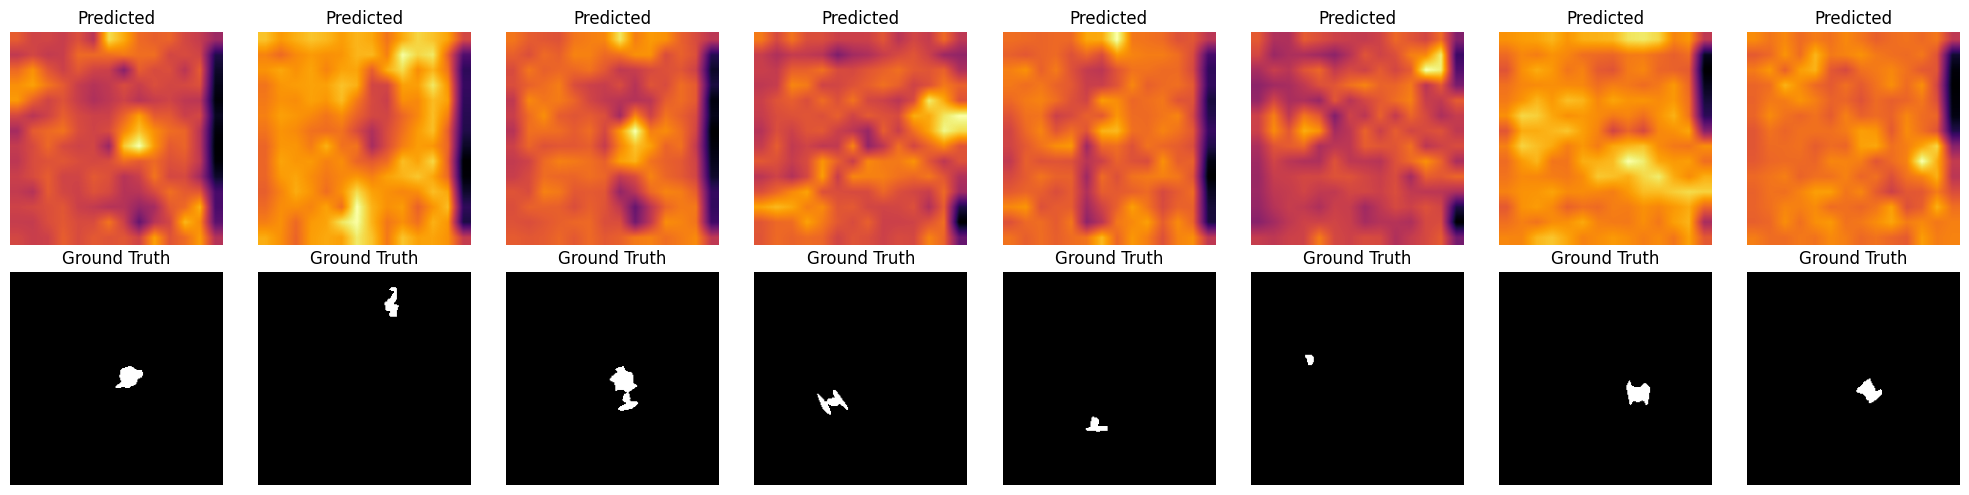


Evaluating category: tile


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



tile: AUROC: 78.86% / 67.79% (image / pixel)


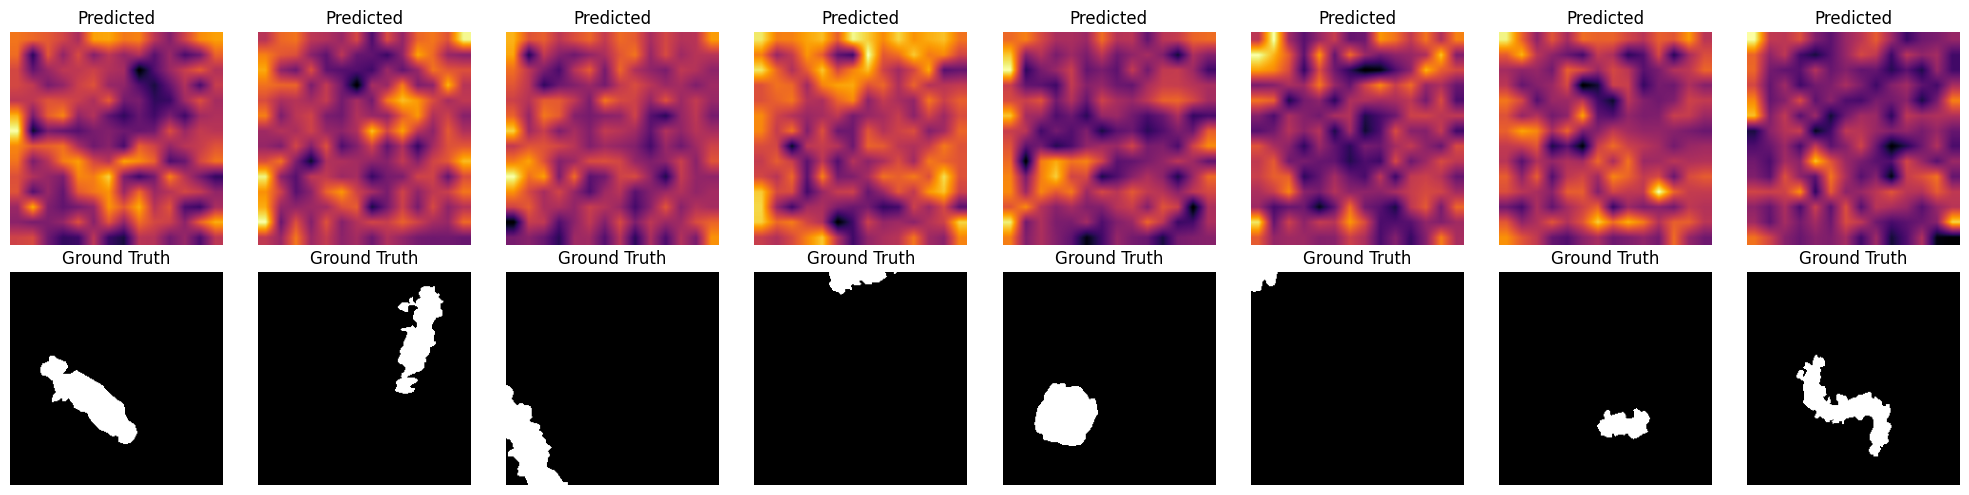


Evaluating category: toothbrush


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



toothbrush: AUROC: 80.83% / 85.73% (image / pixel)


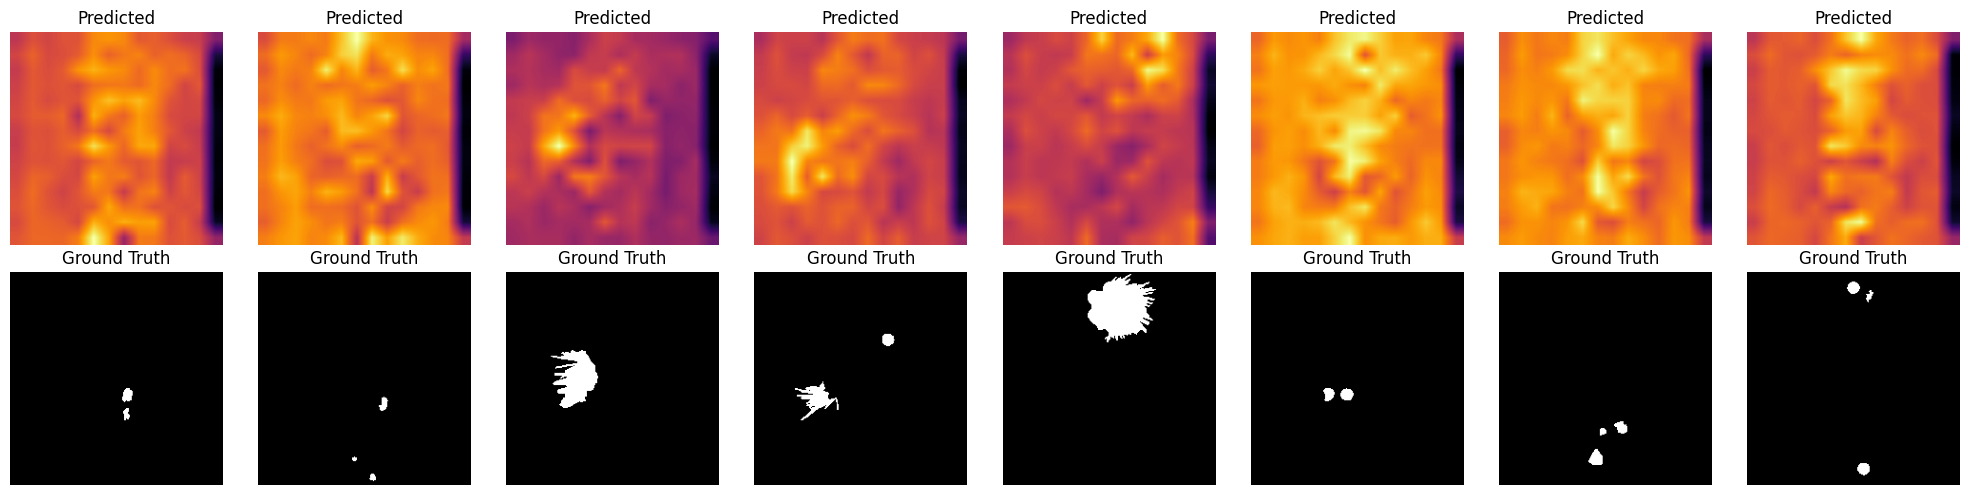


Evaluating category: transistor


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



transistor: AUROC: 77.08% / 79.08% (image / pixel)


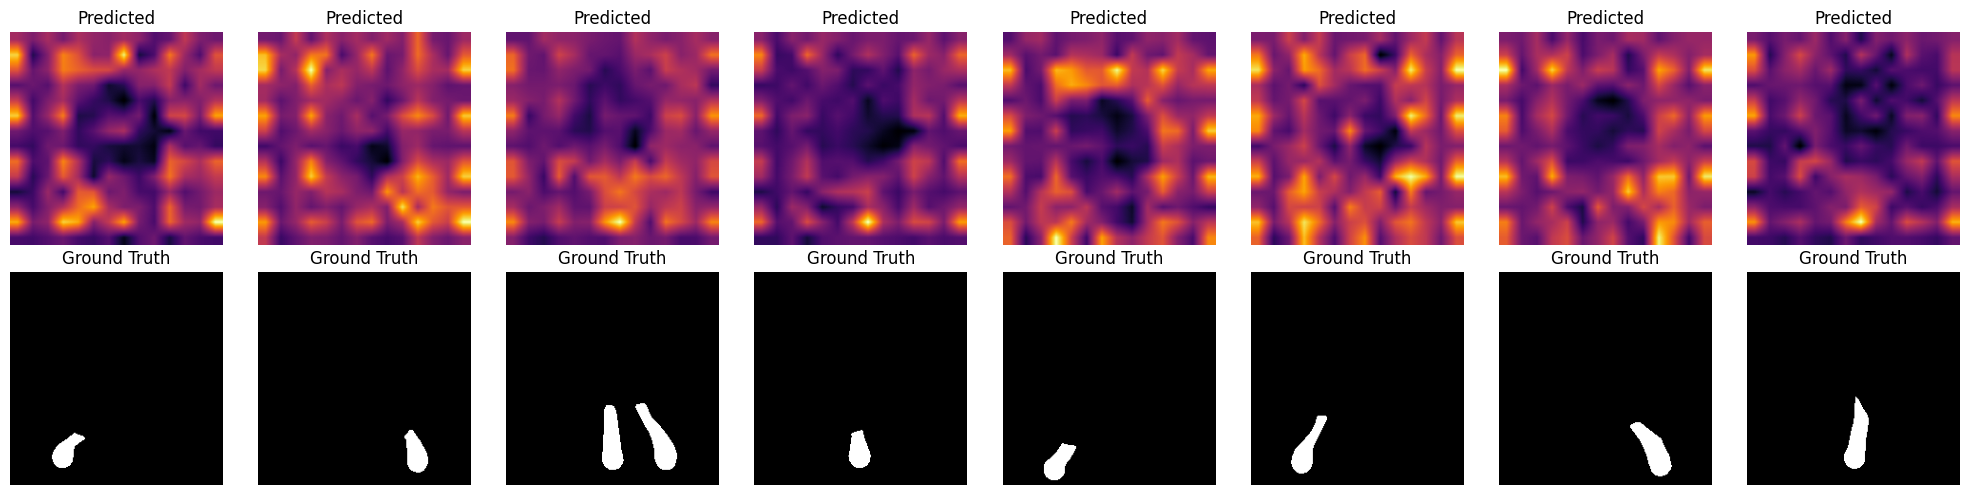


Evaluating category: wood


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



wood: AUROC: 92.98% / 76.82% (image / pixel)


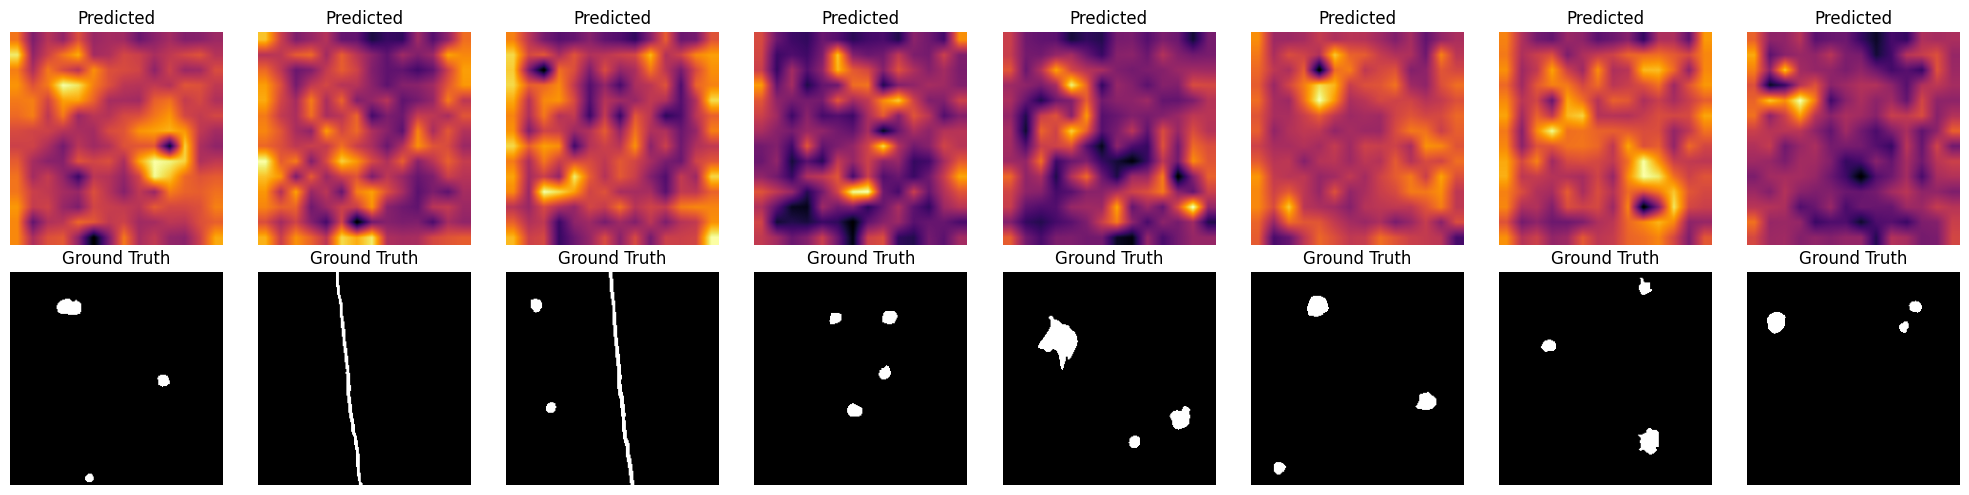


Evaluating category: zipper


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



zipper: AUROC: 98.53% / 92.17% (image / pixel)


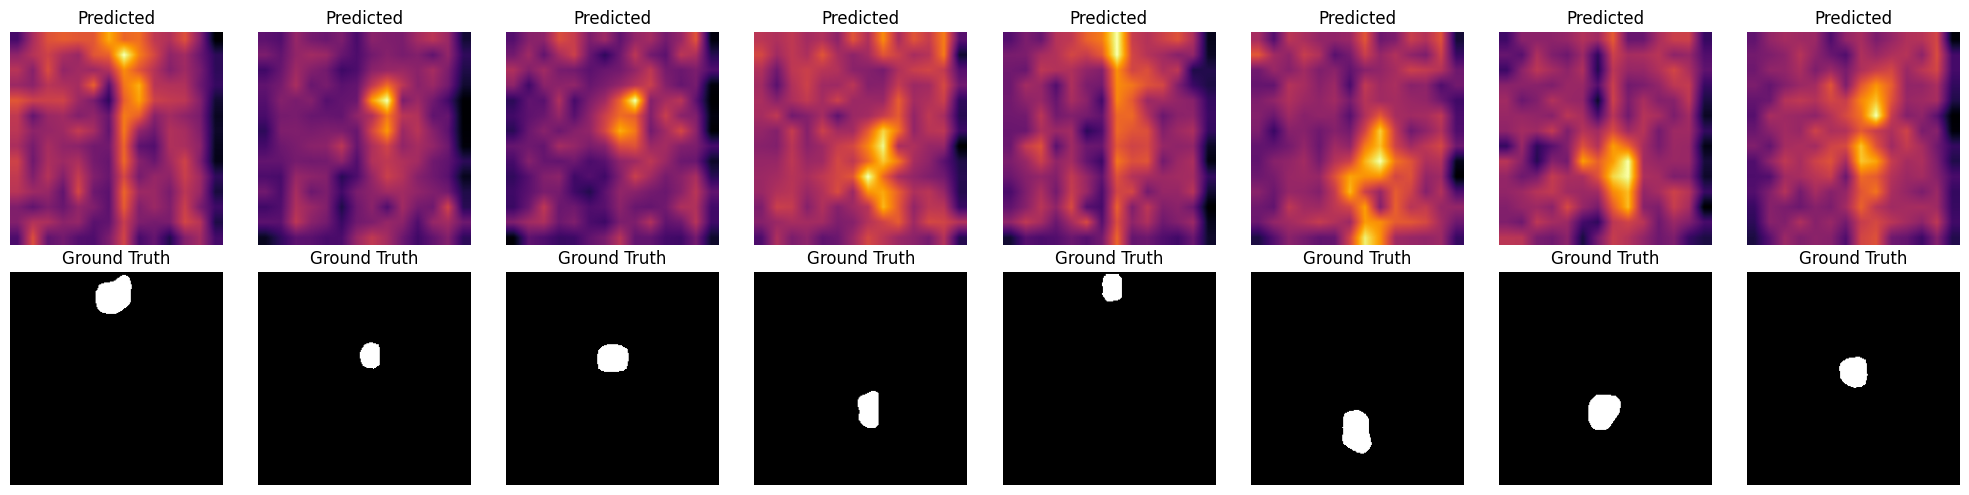

In [23]:
MVTec_ROOT = "/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection"
WEIGHT_DIR = "/kaggle/working/saved_weights"

if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
    ])

    base_path = "/kaggle/input/mvtec-ad-dataset/mvtec_anomaly_detection/mvtec_anomaly_detection"
    categories = sorted([
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ])

    for category in categories:
        print(f"\nEvaluating category: {category}")
        root = os.path.join(MVTec_ROOT, category)
        dataset = MVTecDataset(root, transform, mask=True)
        loader = DataLoader(dataset, batch_size=1, shuffle=False)

        # Load model components
        F_phi = FeatureExtractor().cuda().eval()
        G_theta = FeatureAdapter().cuda().eval()
        D_psi = Discriminator().cuda().eval()

        # Load saved weights
        g_path = os.path.join(WEIGHT_DIR, f"G_theta_{category}.pth")
        d_path = os.path.join(WEIGHT_DIR, f"D_psi_{category}.pth")

        if os.path.exists(g_path) and os.path.exists(d_path):
            G_theta.load_state_dict(torch.load(g_path))
            D_psi.load_state_dict(torch.load(d_path))
        else:
            print(f"Warning: Weights not found for category {category}. Skipping...")
            continue

        # Run evaluation
        evaluate((F_phi, G_theta, D_psi), loader,category)